In [30]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline 

In [31]:
# read in all the words
words = open("names.txt", "r").read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [32]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [33]:
# utility function we will use to compare manual grad with pytorch grad
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [34]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 64  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)

# Layer 1
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)
b1 = (
    torch.randn(n_hidden, generator=g) * 0.1
)  # using b1 just for fun, it's useless because of batchnorm

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

# Note: I am initializing many of these parameters in non-standard ways
# because sometimes initializing with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [35]:
batch_size = 32
n = batch_size  # a shorter variable also, for convenience

# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

In [36]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb]  # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1  # hidden layer pre-activation

# BatchNorm layer
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = (
    1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
)  # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact)  # hidden layer

# Linear layer 2
logits = h @ W2 + b2  # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = (
    counts_sum**-1
)  # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None

for t in [
    logprobs,
    probs,
    counts,
    counts_sum,
    counts_sum_inv,
    norm_logits,
    logit_maxes,
    logits,
    h,
    hpreact,
    bnraw,
    bnvar_inv,
    bnvar,
    bndiff2,
    bndiff,
    hprebn,
    bnmeani,
    embcat,
    emb,
]:
    t.retain_grad()

loss.backward()
loss

tensor(3.3540, grad_fn=<NegBackward0>)

# Excercise 1 


In [37]:
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [38]:
logprobs.shape

torch.Size([32, 27])

In [39]:
logprobs[range(n), Yb]

tensor([-4.0657, -2.9595, -3.6745, -3.2973, -4.1389, -3.5611, -3.1891, -3.9400,
        -3.1708, -4.3764, -3.0727, -1.7421, -2.8173, -2.9052, -3.0742, -3.2179,
        -3.7922, -3.1004, -3.5414, -3.4171, -2.8918, -3.0620, -4.3925, -4.1390,
        -3.4675, -2.7963, -3.0630, -3.9547, -2.7008, -3.4675, -3.3067, -3.0310],
       grad_fn=<IndexBackward0>)

Cross-entropy loss:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi mathvariant="script">L</mi><mo>=</mo><mo>−</mo><munder><mo>∑</mo><mi>k</mi></munder><msub><mi>y</mi><mi>k</mi></msub><mi>log</mi><mo>⁡</mo><mo stretchy="false">(</mo><msub><mi>p</mi><mi>k</mi></msub><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex">\mathcal{L} = - \sum_{k} y_k \log(p_k)</annotation></semantics></math>

Because y is one-hot, only one term survives:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi mathvariant="script">L</mi><mo>=</mo><mo>−</mo><mi>log</mi><mo>⁡</mo><mo stretchy="false">(</mo><msub><mi>p</mi><mtext>true</mtext></msub><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex">\mathcal{L} = - \log(p_{\text{true}})</annotation></semantics></math>

“the model’s predicted probability assigned to the true class”

### dloss / dlogprobs

In [40]:
# dloss / dlogprobs
# dlogprobs = ??
# loss = -logprobs[range(n), Yb].mean()
# loss = -(a + b + c + ..) / n
# loss = -a/3 -b/3 -c/3 + ...
# dloss/ da = -1/3, dloss/ db = -1/3
# dloss/ dn = -1/n

dlogprobs = torch.zeros_like(logprobs) # create 0 value tensors in shape of logprobs
dlogprobs[range(n), Yb] = -1.0 / n

# check
cmp('dlogprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


### dloss/dprobs

In [41]:
# dprobs = ??
# logprobs = probs.log()
# d/dx log(x) = 1/x
# dloss/dprobs = dloss / dlogprobs * dlogprobs / dprobs
# dlogprobs / dprobs = 1 / probs

dprobs = (1.0 / probs) * dlogprobs
# intuitively:
# if a correct prediction has high prob, 1/prob is just 1 and it will just pass through for dlogprobs
# however if a correct prediction has low prob,  1/prob is high, bossting the gradients


# check
cmp("dprobs", dprobs, probs)

dprobs          | exact: True  | approximate: True  | maxdiff: 0.0


### dloss / dcounts_sum_inv

In [43]:
dprobs.shape

torch.Size([32, 27])

In [42]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [ ]:
# c = a * b, but with tensors:
# a[3x3] * b[3,1] ---->
# a11*b1  a12*b1  a13*b1
# a21*b2  a22*b2  a23*b2
# a31*b3  a32*b3  a33*b3
# c[3x3]

In [44]:
# probs = counts * counts_sum_inv
# softmax step exp(n_x)/sum of all exp(n)

# dloss/dcounts_sum_inv = dloss/dprobs * dprobs/dcounts_sum_inv
# dprobs/dcounts_sum_inv = ??
# [ probs = counts * counts_sum_inv ] * d/ d/dcounts
# dprobs/dcounts_sum_inv = counts
# hence
# dloss/dcounts_sum_inv = dloss/dprobs * counts
# REMEBER THAT SINCE THERE IS BROADCASTING, THERE ARE 2 OPERATIONS : REPLICATION & MULTIPLICATION
# counts_sum_inv.shape == torch.Size([32, 1])
# WE JUST HAVE TO SUM FOR ALL THE GRADIENTS CAUSED BY THE MULTIPLICATION OF EACH BROADCASTED ELEMENT
# dprobs.shape == torch.Size([32, 27]) sum across rows
# then shape would match !!!
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)

# check
cmp("dcounts_sum_inv", dcounts_sum_inv, counts_sum_inv)

dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0


### dloss / dcounts part1

In [45]:
# probs = counts * counts_sum_inv
# softmax step exp(n_x)/sum of all exp(n)

# dloss/dcounts = dloss/dprobs * dprobs/dcounts
# dprobs/counts = ??
# [ probs = counts * counts_sum_inv ] * d/ d/dcounts
# dprobs/dcounts = counts_sum_inv
# hence
# dloss/dcounts_sum_inv = dloss/dprobs * counts_sum_inv
# REMEBER THAT SINCE THERE IS BROADCASTING, THERE ARE 2 OPERATIONS : REPLICATION & MULTIPLICATION
# counts_sum_inv.shape == torch.Size([32, 1])
# dcounts = counts_sum_inv([32, 1]) * dprobs([32, 27])
# broadcasting happens itself
dcounts = counts_sum_inv * dprobs

# check
cmp("dcounts", dcounts, counts)
# NOTE 
# false because there is a second branch that depends on dcounts
# counts_sum_inv = counts_sum**-1
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv also contributes to counts_sum which contributes to counts

dcounts         | exact: False | approximate: False | maxdiff: 0.005473533645272255


### dloss / dcounts_sum

In [46]:
# we have derivative of counts_sum_inv, next is counts_sum
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1
# dloss/dcounts_sum = dloss/dcounts_sum_inv * dcounts_sum_inv/dcounts_sum
# dcounts_sum_inv/dcounts_sum ??
# [ counts_sum_inv = counts_sum**-1 ] * d / d/dcounts_sum
# dcounts_sum_inv/dcounts_sum = -counts_sum**-2
# dloss/dcounts_sum = dloss/dcounts_sum_inv * -counts_sum**-2
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

cmp("dcounts_sum", dcounts_sum, counts_sum)

dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0


### dloss / dcounts part2

In [47]:
# counts.shape, counts_sum.shape
# (torch.Size([32, 27]), torch.Size([32, 1]))

# counts_sum = counts.sum(1, keepdims=True)

# a11 a12 a13  --->  b1 (= a11 + a12 + a13)
# a21 a22 a23  --->  b2 (= a21 + a22 + a23)
# a31 a32 a33  --->  b3 (= a31 + a32 + a33)
# "how does b depends on a" is what we are asking
# b1 = a11 + a12 + a13
# db1/a11 = 1
# db1/a12 = 1
# ..
# so in chain rule
# db1/a = local_derivative * derivative of b1
# so basically for a1 1
# dloss/a11 = local_derivative * derivative of b1 = db1/a11 * derivative of b1 = 1 * derivative of b1
# hence it ADDITION IS LIKE A ROUTER
# WHAT EVER GRADIENT WAS COMING FROM ABOVE IS NOW ROUTED/FLOWED EQUALLY FOR ALL ELEMENTS OF ADDITION
# HENCE WE CAN JUST TAKE dcount_sum and replicate it row times

# DOING += BECAUSE DCOUNTS IS BEING CALCULATED 2 TIMES SO WE ADD ITS GRADIENTS FROM 2 BRANCHES
dcounts += torch.ones_like(counts) * dcounts_sum

# check
cmp("dcounts", dcounts, counts)

dcounts         | exact: True  | approximate: True  | maxdiff: 0.0


### dloss / dnorm_logits

In [48]:
# NOW counts = norm_logits.exp()

# dloss/dnorm_logits = local_derivative * derivative of counts
# local_derivative = dcounts/dnorm_logits
# local dericative of e^x is e^x

dnorm_logits = counts * dcounts

# check
cmp("dnorm_logits", dnorm_logits, norm_logits)

dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0


### dloss / dlogits part1 & dloss / dlogit_maxes

In [49]:
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [50]:
dnorm_logits.shape

torch.Size([32, 27])

In [51]:
# NOW norm_logits = logits - logit_maxes

# c11 c12 c13 = a11 a12 a13 - b1
# c21 c22 c23 = a21 a22 a23 - b2
# c31 c32 c33 = a31 a32 a33 - b3
# so e.g. c32 = a32 - b3
# local derivative of c for a is 1 and for b its -1

dlogits = dnorm_logits.clone()  # not the final dlogits, function of dlogit_maxes too 

dlogit_maxes = (-dnorm_logits).sum(dim=1, keepdim=True)

cmp("dlogit_maxes", dlogit_maxes, logit_maxes)

dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0


In [52]:
# norm_logits = logits - logit_maxes  # subtract max for numerical stability

# since subtracting logit_maxes from logits doesnt affect probabilities
# hence that means its gradient from here is 0
# values of these do not matter wrt to final loss! 
# we can see this from dlogit_maxes (v small gradients)
dlogit_maxes

tensor([[-3.7253e-09],
        [ 0.0000e+00],
        [ 1.8626e-09],
        [ 6.5193e-09],
        [ 4.6566e-10],
        [ 2.3283e-09],
        [-2.3283e-09],
        [ 2.7940e-09],
        [-3.7253e-09],
        [ 4.1910e-09],
        [-1.8626e-09],
        [-1.1176e-08],
        [-2.3283e-10],
        [-4.6566e-10],
        [ 2.3283e-10],
        [ 4.6566e-10],
        [ 6.5193e-09],
        [-4.6566e-09],
        [ 2.7940e-09],
        [-4.4238e-09],
        [ 4.6566e-10],
        [-1.8626e-09],
        [ 1.6298e-09],
        [ 1.3970e-09],
        [ 1.8626e-09],
        [ 1.3970e-09],
        [ 4.6566e-10],
        [-4.6566e-10],
        [ 2.7940e-09],
        [ 9.3132e-10],
        [ 1.3970e-09],
        [ 6.5193e-09]], grad_fn=<SumBackward1>)

### dloss / dlogit part2

In [ ]:
# NOW: logit_maxes = logits.max(1, keepdim=True).values

In [53]:
logits.max(1, keepdim=True)
# returns indices of max logit too 

torch.return_types.max(
values=tensor([[1.0336],
        [0.8344],
        [1.0872],
        [0.6467],
        [1.5847],
        [0.8714],
        [0.8120],
        [1.3296],
        [1.0376],
        [1.0121],
        [1.6896],
        [1.9257],
        [1.0903],
        [0.8975],
        [0.5977],
        [0.8455],
        [0.8936],
        [0.7728],
        [1.0903],
        [0.8749],
        [0.7572],
        [1.0301],
        [1.0903],
        [1.1998],
        [1.6018],
        [1.1131],
        [1.2348],
        [1.0170],
        [0.8961],
        [0.7468],
        [1.0592],
        [0.8860]], grad_fn=<MaxBackward0>),
indices=tensor([[ 1],
        [ 2],
        [19],
        [ 4],
        [15],
        [25],
        [16],
        [ 3],
        [ 7],
        [ 8],
        [15],
        [ 3],
        [22],
        [18],
        [ 7],
        [ 5],
        [ 2],
        [ 1],
        [22],
        [19],
        [15],
        [19],
        [22],
        [22],
        [23],
        [

In [60]:
# NOW: logit_maxes = logits.max(1, keepdim=True).values

# gradients only flow back for logits that were max
# 1 for max
# hence dloss/dlogits = local_derivative * dlogit_maxes
# local_derivative = 1 for where max indes was

# ADDING BECAUSE THIS IS 2ND BRANCH FOR dlogits
# populating 1 at max and 0 else where and then multilying by dlogit_maxes gradient
dlogits += F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1]) * dlogit_maxes

# check
cmp("dlogits", dlogits, logits)

dlogits         | exact: True  | approximate: True  | maxdiff: 0.0


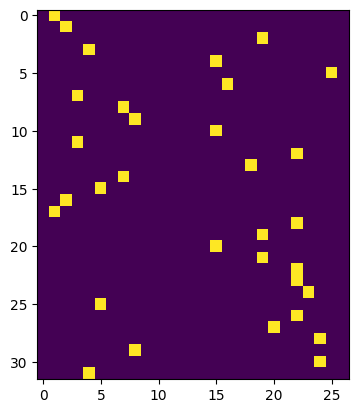

In [58]:
plt.imshow(F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1]))

### dloss/dh & dloss/W2 & dloss/b2

In [61]:
dlogits.shape, h.shape, W2.shape, b2.shape # broadcasting at b2

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [63]:
# NOW: logits = h @ W2 + b2  # output layer

# Forward:
# d = a @ b + c
#
# a: [2x2], b: [2x2], c: [1x2] (broadcasted)
#
# d11 = a11*b11 + a12*b21 + c1
# d12 = a11*b12 + a12*b22 + c2
# d21 = a21*b11 + a22*b21 + c1
# d22 = a21*b12 + a22*b22 + c2


# =========================================================
# Gradient w.r.t. a  (already shown before, kept for flow)
# =========================================================
#
# ∂L/∂a11 = ∂L/∂d11 * b11 + ∂L/∂d12 * b12
# ∂L/∂a12 = ∂L/∂d11 * b21 + ∂L/∂d12 * b22
#
# ∂L/∂a21 = ∂L/∂d21 * b11 + ∂L/∂d22 * b12
# ∂L/∂a22 = ∂L/∂d21 * b21 + ∂L/∂d22 * b22
#
# Matrix form:
# ∂L/∂a = (∂L/∂d) @ bᵀ


# =========================================================
# Gradient w.r.t. b  (DERIVATION)
# =========================================================
#
# Look at how each b_ij contributes to d:
#
# d11 = a11*b11 + a12*b21 + c1
# d21 = a21*b11 + a22*b21 + c1
#
# So b11 affects d11 and d21
#
# ∂L/∂b11 = ∂L/∂d11 * a11 + ∂L/∂d21 * a21
#
#
# d12 = a11*b12 + a12*b22 + c2
# d22 = a21*b12 + a22*b22 + c2
#
# So b12 affects d12 and d22
#
# ∂L/∂b12 = ∂L/∂d12 * a11 + ∂L/∂d22 * a21
#
#
# Similarly:
#
# ∂L/∂b21 = ∂L/∂d11 * a12 + ∂L/∂d21 * a22
# ∂L/∂b22 = ∂L/∂d12 * a12 + ∂L/∂d22 * a22
#
#
# Writing all together:
#
# [∂L/∂b11  ∂L/∂b12] = [a11 a21]ᵀ @ [∂L/∂d11  ∂L/∂d12]
# [∂L/∂b21  ∂L/∂b22]   [a12 a22]    [∂L/∂d21  ∂L/∂d22]
#
# Matrix form:
# ∂L/∂b = aᵀ @ (∂L/∂d)


# =========================================================
# Gradient w.r.t. c  (DERIVATION)
# =========================================================
#
# c is broadcasted across rows:
#
# d11 = ... + c1
# d21 = ... + c1
#
# d12 = ... + c2
# d22 = ... + c2
#
# So:
#
# ∂d11/∂c1 = 1,  ∂d21/∂c1 = 1
# ∂d12/∂c2 = 1,  ∂d22/∂c2 = 1
#
# Applying chain rule:
#
# ∂L/∂c1 = ∂L/∂d11 * 1 + ∂L/∂d21 * 1
# ∂L/∂c2 = ∂L/∂d12 * 1 + ∂L/∂d22 * 1
#
# Vector form:
# ∂L/∂c = sum over rows of (∂L/∂d)
#
# i.e.
# ∂L/∂c = (∂L/∂d).sum(dim=0)


# =========================================================
# Final gradient identities (to memorize)
# =========================================================
#
# If: d = a @ b + c
#
# then:
# ∂L/∂a = (∂L/∂d) @ bᵀ
# ∂L/∂b = aᵀ @ (∂L/∂d)
# ∂L/∂c = (∂L/∂d).sum(0)
#
# This is EXACTLY what PyTorch autograd computes internally.

# THE BACKWARD PASS OF A MATRIX MULTIPLY IS THE MATRIX MULIPLY

# trick:
# - dh should be shape of h : torch.Size([32, 64]
# - logits = h @ W2 + b2
# - we know dh should be some mulitplication of >>>dlogits with W2<<<
# - dlogit is torch.Size([32, 27]
# - W2 is torch.Size([64, 27]
# - only way to multiply these matrices correctly is dlogits * W2^T
dh = dlogits @ W2.T
# similarly
dW2 = h.T @ dlogits

# bias is just the sum across rows
# we know sum is across rows becuase we need db2 to to be te same size as b2: torch.Size([27]
# dlogits shape is torch.Size([32, 27]
# hence sum across dim=0
db2 = dlogits.sum(dim=0)

# check
cmp("dh", dh, h)
cmp("dW2", dW2, W2)
cmp("b2", db2, b2)

dh              | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


In [62]:
dlogits.shape, h.shape, W2.shape, b2.shape  # broadcasting at b2

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

### dloss / dhpreact

In [64]:
# NOW: h = torch.tanh(hpreact)

# dloss / dhpreact = local gradient * dh
# local gradient = derivative of torch.tanh(hpreact)
# d/dx(tanh(x)) = sech(x)^2 = 1 - tan(x)^2
# derivative of tanh is 1-(output of tanh)^2

dhpreact = (1.0 - h**2) * dh

cmp("dhpreact", dhpreact, hpreact)

dhpreact        | exact: True  | approximate: True  | maxdiff: 0.0


### dloss/dbngain & dloss/dbnraw part1 & dloss/dbnbias

In [65]:
hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

In [66]:
dhpreact.shape

torch.Size([32, 64])

In [67]:
# NOW: hpreact = bngain * bnraw + bnbias

# bngain size is torch.Size([1, 64]
# elemnt-wise multiplication
# bnraw * dhpreact will be [32, 64]
# sum row wise
dbngain = (bnraw * dhpreact).sum(dim=0, keepdim=True)
dbnraw = bngain * dhpreact # broadcast 
# gradients just flow directly into biases always
dbnbias = dhpreact.sum(dim=0, keepdim=True)

cmp("dbngain", dbngain, bngain)
cmp("dbnraw", dbnraw, bnraw)
cmp("dbnbias", dbnbias, bnbias)

dbngain         | exact: True  | approximate: True  | maxdiff: 0.0
dbnraw          | exact: True  | approximate: True  | maxdiff: 0.0
dbnbias         | exact: True  | approximate: True  | maxdiff: 0.0


### dbndiff part1 & bndiff

In [68]:
bnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [69]:
dbnraw.shape

torch.Size([32, 64])

In [70]:
# NOW: bnraw = bndiff * bnvar_inv

# part1: has another branch
dbndiff = bnvar_inv * dbnraw
# keep checking dims of result and the element wise multiplication elements
# to see if the result x matches dx
dbnvar_inv = (bndiff * dbnraw).sum(dim=0, keepdim=True)

cmp("dbndiff", dbndiff, bndiff)
cmp("dbnvar_inv", dbnvar_inv, bnvar_inv)

dbndiff         | exact: False | approximate: False | maxdiff: 0.0011457442305982113
dbnvar_inv      | exact: True  | approximate: True  | maxdiff: 0.0


### dbnvar

In [71]:
# NOW: bnvar_inv = (bnvar + 1e-5) ** -0.5

dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * 1 * dbnvar_inv

cmp("dbnvar", dbnvar, bnvar)

dbnvar          | exact: True  | approximate: True  | maxdiff: 0.0


### dbndiff2

In [72]:
bnvar.shape, bndiff2.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [73]:
dbnvar.shape

torch.Size([1, 64])

In [74]:
# NOW : bnvar = ( 1 / (n - 1) * (bndiff2).sum(0, keepdim=True))  # note: Bessel's correction (dividing by n-1, not n)

# WHEN WE HAVE A SUM IN FORWARD PASS
# IT TURNS INTO BROADCAST IN BACKWARD

# WHEN WE HAVE A BROADCAST IN FORWARD
# IT TURNS INTO SUM IN BACKWARD

# a11  a12
# a21  a22
# ---->
# b1, b2, where:
# b1 = 1/(n-1) * (a11 + a21)
# b2 = 1/(n-1) * (a12 + a22)

# derivative of b1 wrt a11, a21
# is 1/(n-1) * db1
# replicating across all row sum

dbndiff2 = (1 / (n - 1)) * torch.ones_like(bndiff2) * dbnvar # broadcasting 

cmp("dbndiff2", dbndiff2, bndiff2)

dbndiff2        | exact: True  | approximate: True  | maxdiff: 0.0


### dbndiff part2

In [75]:
# NOW: bndiff2 = bndiff**2

dbndiff += (2 * bndiff) * dbndiff2

cmp("dbndiff", dbndiff, bndiff)

dbndiff         | exact: True  | approximate: True  | maxdiff: 0.0


### dhprebn part1 & dbnmeani

In [76]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [77]:
# NOW: bndiff = hprebn - bnmeani

dhprebn = 1.0 * dbndiff.clone()
dbnmeani = (-dbndiff).sum(dim=0, keepdim=True)

# is wrong because 2 branch
cmp("dhprebn", dhprebn, hprebn)
cmp("dbnmeani", dbnmeani, bnmeani)

dhprebn         | exact: False | approximate: False | maxdiff: 0.0010110712610185146
dbnmeani        | exact: True  | approximate: True  | maxdiff: 0.0


### dhprebn part2

In [78]:
# NOW: bnmeani = 1 / n * hprebn.sum(0, keepdim=True)

dhprebn +=  1.0 / n * (torch.ones_like(hprebn) * dbnmeani)

cmp("dhprebn", dhprebn, hprebn)

dhprebn         | exact: True  | approximate: True  | maxdiff: 0.0


### dembcat & dW1 & db1

In [79]:
hprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [80]:
# NOW: hprebn = embcat @ W1 + b1  # hidden layer pre-activation

# do the trick here !
# dembcat [32, 30]
dembcat = dhprebn @ W1.T 

# dW1 [30, 64]
dW1 = embcat.T @ dhprebn

# db1 [64]
db1 = dhprebn.sum(dim=0)

cmp("dembcat", dembcat, embcat)
cmp("dW1", dW1, W1)
cmp("db1", db1, b1)

dembcat         | exact: True  | approximate: True  | maxdiff: 0.0
dW1             | exact: True  | approximate: True  | maxdiff: 0.0
db1             | exact: True  | approximate: True  | maxdiff: 0.0


### demb

In [81]:
embcat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

In [82]:
# NOW: embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
# concating torch.Size([32, 3, 10] 3, 10 dimensional
# so just need to unconcat it
demb = dembcat.view(emb.shape)

cmp("demb", demb, emb)

demb            | exact: True  | approximate: True  | maxdiff: 0.0


### dC

In [83]:
emb.shape , C.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]))

In [84]:
Xb.shape

torch.Size([32, 3])

In [87]:
# NOW: emb = C[Xb]  # embed the characters into vectors
# C row represents rows --> embeddings for a char
# if a row was used multiple times we need to add them too

# we took row of C as index
# and added it to emb at k,j for embeddings
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

cmp("dC", dC, C)

dC              | exact: True  | approximate: True  | maxdiff: 0.0


## bringing it together

In [ ]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# dlogprobs = torch.zeros_like(logprobs)
# dlogprobs[range(n), Yb] = -1.0 / n
# dprobs = (1.0 / probs) * dlogprobs
# dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
# dcounts = counts_sum_inv * dprobs
# dcounts_sum = (-(counts_sum**-2)) * dcounts_sum_inv
# dcounts += torch.ones_like(counts) * dcounts_sum
# dnorm_logits = counts * dcounts
# dlogits = dnorm_logits.clone()
# dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
# dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
# dh = dlogits @ W2.T
# dW2 = h.T @ dlogits
# db2 = dlogits.sum(0)
# dhpreact = (1.0 - h**2) * dh
# dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
# dbnraw = bngain * dhpreact
# dbnbias = dhpreact.sum(0, keepdim=True)
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
# dbndiff2 = (1.0 / (n - 1)) * torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2 * bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0 / n * (torch.ones_like(hprebn) * dbnmeani)
# dembcat = dhprebn @ W1.T
# dW1 = embcat.T @ dhprebn
# db1 = dhprebn.sum(0)
# demb = dembcat.view(emb.shape)
# dC = torch.zeros_like(C)
# for k in range(Xb.shape[0]):
#     for j in range(Xb.shape[1]):
#         ix = Xb[k, j]
#         dC[ix] += demb[k, j]

# cmp("logprobs", dlogprobs, logprobs)
# cmp("probs", dprobs, probs)
# cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
# cmp("counts_sum", dcounts_sum, counts_sum)
# cmp("counts", dcounts, counts)
# cmp("norm_logits", dnorm_logits, norm_logits)
# cmp("logit_maxes", dlogit_maxes, logit_maxes)
# cmp("logits", dlogits, logits)
# cmp("h", dh, h)
# cmp("W2", dW2, W2)
# cmp("b2", db2, b2)
# cmp("hpreact", dhpreact, hpreact)
# cmp("bngain", dbngain, bngain)
# cmp("bnbias", dbnbias, bnbias)
# cmp("bnraw", dbnraw, bnraw)
# cmp("bnvar_inv", dbnvar_inv, bnvar_inv)
# cmp("bnvar", dbnvar, bnvar)
# cmp("bndiff2", dbndiff2, bndiff2)
# cmp("bndiff", dbndiff, bndiff)
# cmp("bnmeani", dbnmeani, bnmeani)
# cmp("hprebn", dhprebn, hprebn)
# cmp("embcat", dembcat, embcat)
# cmp("W1", dW1, W1)
# cmp("b1", db1, b1)
# cmp("emb", demb, emb)
# cmp("C", dC, C)

In [88]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), "diff:", (loss_fast - loss).item())

3.3539576530456543 diff: 0.0


In [ ]:
# ============================================================
# Softmax + Cross-Entropy (single example x, label y)
# Full forward + backward derivation in comments
# ============================================================

# Forward pass:
#
# x --(NN with weights W)--> logits (l)
# logits --softmax--> probs (p)
#
# probs[y] --(-log)--> loss
#
# -----------------------------------------
# Softmax:
#
# p_i = exp(l_i) / sum_j exp(l_j)
#
# -----------------------------------------
# Loss (negative log-likelihood):
#
# loss = -log(p_y)
#      = -log( exp(l_y) / sum_j exp(l_j) )
#
# -----------------------------------------
# Backward pass: d(loss) / d(l_i)
#
# Start from:
#
# loss = -log( exp(l_y) / sum_j exp(l_j) )
#
# Using:
# d/dx [log x] = 1 / x
#
# -----------------------------------------
# Case 1: i != y
#
# d(loss)/d(l_i)
# = - d/d(l_i) [ log( exp(l_y) / sum_j exp(l_j) ) ]
#
# = - (sum_j exp(l_j) / exp(l_y)) * d/d(l_i) [ exp(l_y) / sum_j exp(l_j) ]
#
# Since i != y:
# d(exp(l_y))/d(l_i) = 0
#
# Only denominator contributes:
#
# = + exp(l_i) / sum_j exp(l_j)
#
# = p_i
#
# -----------------------------------------
# Case 2: i == y
#
# d(loss)/d(l_y)
# = - d/d(l_y) [ log( exp(l_y) / sum_j exp(l_j) ) ]
#
# Apply quotient + product rule:
#
# = - [ (sum_j exp(l_j) * exp(l_y) - exp(l_y) * exp(l_y)) / (sum_j exp(l_j))^2 ]
#
# = - [ (sum_j exp(l_j) - exp(l_y)) / sum_j exp(l_j) ]
#
# = exp(l_y) / sum_j exp(l_j) - 1
#
# = p_y - 1
#
# -----------------------------------------
# Final gradient (combined form):
#
# d(loss)/d(l_i) =
#   p_i - 1    if i == y
#   p_i        if i != y
#
# -----------------------------------------
# Vector form (very important):
#
# dL/dlogits = probs
# dL/dlogits[y] -= 1
#
# -----------------------------------------
# Key insight:
#
# Softmax + Cross-Entropy collapses into a
# single clean gradient step:
#
#     grad = probs - one_hot(y)
#
# This is why frameworks (PyTorch, TensorFlow)
# fuse softmax + cross-entropy into ONE operation
# for numerical stability and efficiency.
#
# ============================================================

# Cross-Entropy Loss and Backward Pass (Mathematical Derivation)

We start from one training example.

Given

logits:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi mathvariant="bold">z</mi><mo>=</mo><mo stretchy="false">(</mo><msub><mi>z</mi><mn>1</mn></msub><mo separator="true">,</mo><msub><mi>z</mi><mn>2</mn></msub><mo separator="true">,</mo><mo>…</mo><mo separator="true">,</mo><msub><mi>z</mi><mi>K</mi></msub><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex">\mathbf{z} = (z_1, z_2, \dots, z_K)</annotation></semantics></math>
true class index:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>y</mi></mrow><annotation encoding="application/x-tex">y</annotation></semantics></math>

Step 1: Softmax
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mi>p</mi><mi>i</mi></msub><mo>=</mo><mfrac><msup><mi>e</mi><msub><mi>z</mi><mi>i</mi></msub></msup><mrow><munder><mo>∑</mo><mi>j</mi></munder><msup><mi>e</mi><msub><mi>z</mi><mi>j</mi></msub></msup></mrow></mfrac></mrow><annotation encoding="application/x-tex">p_i = \frac{e^{z_i}}{\sum_j e^{z_j}}</annotation></semantics></math>
Step 2: Cross-entropy loss
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>L</mi><mo>=</mo><mo>−</mo><munder><mo>∑</mo><mi>i</mi></munder><msub><mi>y</mi><mi>i</mi></msub><mi>log</mi><mo>⁡</mo><msub><mi>p</mi><mi>i</mi></msub></mrow><annotation encoding="application/x-tex">L = -\sum_i y_i \log p_i</annotation></semantics></math>
where y_i is one-hot.

Since only y_y = 1, everything else is zero:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><menclose notation="box"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="true"><mrow><mi>L</mi><mo>=</mo><mo>−</mo><mi>log</mi><mo>⁡</mo><mo stretchy="false">(</mo><msub><mi>p</mi><mi>y</mi></msub><mo stretchy="false">)</mo></mrow></mstyle></mstyle></mstyle></menclose></mrow><annotation encoding="application/x-tex">\boxed{L = -\log(p_y)}</annotation></semantics></math>

## Rewrite loss in a differentiable form
Now plug softmax into the loss.
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>L</mi><mo>=</mo><mo>−</mo><mi>log</mi><mo>⁡</mo><mrow><mo fence="true">(</mo><mfrac><msup><mi>e</mi><msub><mi>z</mi><mi>y</mi></msub></msup><mrow><munder><mo>∑</mo><mi>j</mi></munder><msup><mi>e</mi><msub><mi>z</mi><mi>j</mi></msub></msup></mrow></mfrac><mo fence="true">)</mo></mrow></mrow><annotation encoding="application/x-tex">L = -\log\left(\frac{e^{z_y}}{\sum_j e^{z_j}}\right)</annotation></semantics></math>
Use log rules:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><menclose notation="box"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="true"><mrow><mi>L</mi><mo>=</mo><mo>−</mo><msub><mi>z</mi><mi>y</mi></msub><mo>+</mo><mi>log</mi><mo>⁡</mo><mrow><mo fence="true">(</mo><munder><mo>∑</mo><mi>j</mi></munder><msup><mi>e</mi><msub><mi>z</mi><mi>j</mi></msub></msup><mo fence="true">)</mo></mrow></mrow></mstyle></mstyle></mstyle></menclose></mrow><annotation encoding="application/x-tex">\boxed{L = -z_y + \log\left(\sum_j e^{z_j}\right)}</annotation></semantics></math>
This step is crucial because now the loss is written directly in terms of logits.

## Differentiate w.r.t. logits
We now compute:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>z</mi><mi>i</mi></msub></mrow></mfrac></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial z_i}</annotation></semantics></math>
Take derivatives term by term.

### Term 1: -z_y

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mo stretchy="false">(</mo><mo>−</mo><msub><mi>z</mi><mi>y</mi></msub><mo stretchy="false">)</mo></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>z</mi><mi>i</mi></msub></mrow></mfrac><mo>=</mo><mrow><mo fence="true">{</mo><mtable rowspacing="0.36em" columnalign="left left" columnspacing="1em"><mtr><mtd><mstyle scriptlevel="0" displaystyle="false"><mrow><mo>−</mo><mn>1</mn></mrow></mstyle></mtd><mtd><mstyle scriptlevel="0" displaystyle="false"><mrow><mi>i</mi><mo>=</mo><mi>y</mi></mrow></mstyle></mtd></mtr><mtr><mtd><mstyle scriptlevel="0" displaystyle="false"><mn>0</mn></mstyle></mtd><mtd><mstyle scriptlevel="0" displaystyle="false"><mrow><mi>i</mi><mo mathvariant="normal">≠</mo><mi>y</mi></mrow></mstyle></mtd></mtr></mtable></mrow></mrow><annotation encoding="application/x-tex">\frac{\partial (-z_y)}{\partial z_i}=\begin{cases}-1 &amp; i = y \\0 &amp; i \neq y\end{cases}</annotation></semantics></math>

Term 2: log(sigma_j(e^zj))

Apply chain rule:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mi mathvariant="normal">∂</mi><mrow><mi mathvariant="normal">∂</mi><msub><mi>z</mi><mi>i</mi></msub></mrow></mfrac><mi>log</mi><mo>⁡</mo><mrow><mo fence="true">(</mo><munder><mo>∑</mo><mi>j</mi></munder><msup><mi>e</mi><msub><mi>z</mi><mi>j</mi></msub></msup><mo fence="true">)</mo></mrow><mo>=</mo><mfrac><mn>1</mn><mrow><munder><mo>∑</mo><mi>j</mi></munder><msup><mi>e</mi><msub><mi>z</mi><mi>j</mi></msub></msup></mrow></mfrac><mo>⋅</mo><msup><mi>e</mi><msub><mi>z</mi><mi>i</mi></msub></msup></mrow><annotation encoding="application/x-tex">\frac{\partial}{\partial z_i}
\log\left(\sum_j e^{z_j}\right)=\frac{1}{\sum_j e^{z_j}} \cdot e^{z_i}</annotation></semantics></math>
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><menclose notation="box"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="true"><mrow><mo>=</mo><mfrac><msup><mi>e</mi><msub><mi>z</mi><mi>i</mi></msub></msup><mrow><munder><mo>∑</mo><mi>j</mi></munder><msup><mi>e</mi><msub><mi>z</mi><mi>j</mi></msub></msup></mrow></mfrac><mo>=</mo><msub><mi>p</mi><mi>i</mi></msub></mrow></mstyle></mstyle></mstyle></menclose></mrow><annotation encoding="application/x-tex">\boxed{= \frac{e^{z_i}}{\sum_j e^{z_j}} = p_i}</annotation></semantics></math>
This is exactly the softmax probability.

### Combine both terms

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>z</mi><mi>i</mi></msub></mrow></mfrac><mo>=</mo><msub><mi>p</mi><mi>i</mi></msub><mo>−</mo><msub><mn mathvariant="bold">1</mn><mrow><mi>i</mi><mo>=</mo><mi>y</mi></mrow></msub></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial z_i}=p_i - \mathbf{1}_{i=y}</annotation></semantics></math>

## Why this becomes (softmax − one_hot)
Left:

probs = softmax(logits)

y = true class index

Then mathematically:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mi mathvariant="normal">∇</mi><mtext>logits</mtext></msub><mi>L</mi><mo>=</mo><mtext>probs</mtext><mo>−</mo><mtext>one_hot</mtext><mo stretchy="false">(</mo><mi>y</mi><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex">\nabla_{\text{logits}} L = \text{probs} - \text{one\_hot}(y)</annotation></semantics></math>


In [ ]:
# backward pass
dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1 
dlogits /= n 

cmp("dlogits", dlogits, logits) # approximate bec of floating points

dlogits         | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [91]:
F.softmax(logits, 1)[0]

tensor([0.0614, 0.0907, 0.0188, 0.0474, 0.0213, 0.0803, 0.0232, 0.0366, 0.0172,
        0.0296, 0.0408, 0.0354, 0.0361, 0.0304, 0.0385, 0.0141, 0.0091, 0.0194,
        0.0177, 0.0534, 0.0505, 0.0212, 0.0263, 0.0765, 0.0567, 0.0255, 0.0220],
       grad_fn=<SelectBackward0>)

In [92]:
dlogits[0] * n

tensor([ 0.0614,  0.0907,  0.0188,  0.0474,  0.0213,  0.0803,  0.0232,  0.0366,
        -0.9828,  0.0296,  0.0408,  0.0354,  0.0361,  0.0304,  0.0385,  0.0141,
         0.0091,  0.0194,  0.0177,  0.0534,  0.0505,  0.0212,  0.0263,  0.0765,
         0.0567,  0.0255,  0.0220], grad_fn=<MulBackward0>)

i ≠ y (wrong classes)
- “Push this logit DOWN proportional to how confident you were”

i = y (correct class)
- Zero gradient when p_y = 1
- Negative gradient when p_y < 1 (push it up)

For all classes at once:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><menclose notation="box"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="true"><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><mtext>logits</mtext></mrow></mfrac><mo>=</mo><mtext>probs</mtext><mo>−</mo><mtext>one_hot</mtext><mo stretchy="false">(</mo><mi>y</mi><mo stretchy="false">)</mo></mrow></mstyle></mstyle></mstyle></menclose></mrow><annotation encoding="application/x-tex">\boxed{
\frac{\partial L}{\partial \text{logits}} = \text{probs} - \text{one\_hot}(y)
}</annotation></semantics></math>

In [93]:
dlogits[0].sum()

tensor(1.8626e-09, grad_fn=<SumBackward0>)

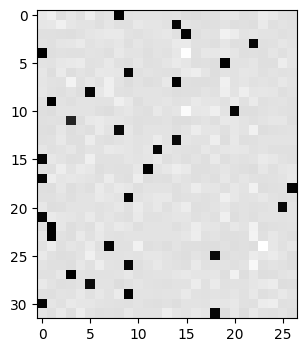

In [90]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap="gray")

In [94]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = (
    bngain
    * (hprebn - hprebn.mean(0, keepdim=True))
    / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5)
    + bnbias
)
print("max diff:", (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = (
    bngain
    * bnvar_inv
    / n
    * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
)

cmp(
    "hprebn", dhprebn, hprebn
)  # I can only get approximate to be true, my maxdiff is 9e-10

Each <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi>x</mi><mi>i</mi></msub></mrow><annotation encoding="application/x-tex">x_i</annotation></semantics></math> affects the loss in three different ways:

- Directly through its own normalized value <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow><annotation encoding="application/x-tex">\hat{x}_i</annotation></semantics></math>
- Indirectly through the batch mean <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi>μ</mi></mrow><annotation encoding="application/x-tex">\mu</annotation></semantics></math>
- Indirectly through the batch variance <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msup><mi>σ</mi><mn>2</mn></msup></mrow><annotation encoding="application/x-tex">\sigma^2</annotation></semantics></math>

So by the chain rule: 
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><menclose notation="box"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="true"><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>x</mi><mi>i</mi></msub></mrow></mfrac><mo>=</mo><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow></mfrac><mfrac><mrow><mi mathvariant="normal">∂</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>x</mi><mi>i</mi></msub></mrow></mfrac><mo>+</mo><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><mi>μ</mi></mrow></mfrac><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>μ</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>x</mi><mi>i</mi></msub></mrow></mfrac><mo>+</mo><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msup><mi>σ</mi><mn>2</mn></msup></mrow></mfrac><mfrac><mrow><mi mathvariant="normal">∂</mi><msup><mi>σ</mi><mn>2</mn></msup></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>x</mi><mi>i</mi></msub></mrow></mfrac></mrow></mstyle></mstyle></mstyle></menclose></mrow><annotation encoding="application/x-tex">\boxed{
\frac{\partial L}{\partial x_i}=\frac{\partial L}{\partial \hat{x}_i}\frac{\partial \hat{x}_i{\partial x_i}+\frac{\partial L}{\partial \mu}\frac{\partial \mu}{\partial x_i}+\frac{\partial L}{\partial \sigma^2}\frac{\partial \sigma^2}{\partial x_i}}</annotation></semantics></math>

### Gradient flows through γ first
From:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mi>y</mi><mi>i</mi></msub><mo>=</mo><mi>γ</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub><mo>+</mo><mi>β</mi></mrow><annotation encoding="application/x-tex">y_i = \gamma \hat{x}_i + \beta</annotation></semantics></math>
Derivative:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow></mfrac><mo>=</mo><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>y</mi><mi>i</mi></msub></mrow></mfrac><mo>⋅</mo><mi>γ</mi></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial \hat{x}_i}=\frac{\partial L}{\partial y_i} \cdot \gamma</annotation></semantics></math>

### Gradient wrt variance 
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub><mo>=</mo><mo stretchy="false">(</mo><msub><mi>x</mi><mi>i</mi></msub><mo>−</mo><mi>μ</mi><mo stretchy="false">)</mo><mo stretchy="false">(</mo><msup><mi>σ</mi><mn>2</mn></msup><mo>+</mo><mi>ε</mi><msup><mo stretchy="false">)</mo><mrow><mo>−</mo><mn>1</mn><mi mathvariant="normal">/</mi><mn>2</mn></mrow></msup></mrow><annotation encoding="application/x-tex">\hat{x}_i = (x_i - \mu)(\sigma^2 + \varepsilon)^{-1/2}</annotation></semantics></math>
Differentiate wrt variance
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow><mrow><mi mathvariant="normal">∂</mi><msup><mi>σ</mi><mn>2</mn></msup></mrow></mfrac><mo>=</mo><mo>−</mo><mfrac><mn>1</mn><mn>2</mn></mfrac><mo stretchy="false">(</mo><msub><mi>x</mi><mi>i</mi></msub><mo>−</mo><mi>μ</mi><mo stretchy="false">)</mo><mo stretchy="false">(</mo><msup><mi>σ</mi><mn>2</mn></msup><mo>+</mo><mi>ε</mi><msup><mo stretchy="false">)</mo><mrow><mo>−</mo><mn>3</mn><mi mathvariant="normal">/</mi><mn>2</mn></mrow></msup></mrow><annotation encoding="application/x-tex">\frac{\partial \hat{x}_i}{\partial \sigma^2}=-\frac{1}{2}(x_i - \mu)(\sigma^2 + \varepsilon)^{-3/2}</annotation></semantics></math>
Now sum over all i because variance affects every <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow><annotation encoding="application/x-tex">\hat{x}_i</annotation></semantics></math>. 
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msup><mi>σ</mi><mn>2</mn></msup></mrow></mfrac><mo>=</mo><munder><mo>∑</mo><mi>i</mi></munder><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow></mfrac><mfrac><mrow><mi mathvariant="normal">∂</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow><mrow><mi mathvariant="normal">∂</mi><msup><mi>σ</mi><mn>2</mn></msup></mrow></mfrac></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial \sigma^2}=\sum_i\frac{\partial L}{\partial \hat{x}_i}\frac{\partial \hat{x}_i}{\partial \sigma^2}</annotation></semantics></math>

### Gradient wrt mean
Mean affects <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow><annotation encoding="application/x-tex">\hat{x}_i</annotation></semantics></math> in two ways:
#### Path A — direct
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow><mrow><mi mathvariant="normal">∂</mi><mi>μ</mi></mrow></mfrac><mo>=</mo><mo>−</mo><mo stretchy="false">(</mo><msup><mi>σ</mi><mn>2</mn></msup><mo>+</mo><mi>ε</mi><msup><mo stretchy="false">)</mo><mrow><mo>−</mo><mn>1</mn><mi mathvariant="normal">/</mi><mn>2</mn></mrow></msup></mrow><annotation encoding="application/x-tex">\frac{\partial \hat{x}_i}{\partial \mu}=-(\sigma^2 + \varepsilon)^{-1/2}</annotation></semantics></math>

#### Path B — indirect via variance
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><msup><mi>σ</mi><mn>2</mn></msup></mrow><mrow><mi mathvariant="normal">∂</mi><mi>μ</mi></mrow></mfrac><mo>=</mo><mo>−</mo><mfrac><mn>2</mn><mrow><mi>m</mi><mo>−</mo><mn>1</mn></mrow></mfrac><munder><mo>∑</mo><mi>i</mi></munder><mo stretchy="false">(</mo><msub><mi>x</mi><mi>i</mi></msub><mo>−</mo><mi>μ</mi><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex">\frac{\partial \sigma^2}{\partial \mu}=-\frac{2}{m-1}\sum_i (x_i - \mu)</annotation></semantics></math>
But:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><munder><mo>∑</mo><mi>i</mi></munder><mo stretchy="false">(</mo><msub><mi>x</mi><mi>i</mi></msub><mo>−</mo><mi>μ</mi><mo stretchy="false">)</mo><mo>=</mo><mn>0</mn></mrow><annotation encoding="application/x-tex">\sum_i (x_i - \mu) = 0</annotation></semantics></math>
So this entire term vanishes.
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><mi>μ</mi></mrow></mfrac><mo>=</mo><mo>−</mo><munder><mo>∑</mo><mi>i</mi></munder><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow></mfrac><mo stretchy="false">(</mo><msup><mi>σ</mi><mn>2</mn></msup><mo>+</mo><mi>ε</mi><msup><mo stretchy="false">)</mo><mrow><mo>−</mo><mn>1</mn><mi mathvariant="normal">/</mi><mn>2</mn></mrow></msup></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial \mu}=-\sum_i\frac{\partial L}{\partial \hat{x}_i}(\sigma^2 + \varepsilon)^{-1/2}</annotation></semantics></math>

### Gradient wrt input
Now we combine everything.
#### Contribution 1 — direct path
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>x</mi><mi>i</mi></msub></mrow></mfrac><mo>=</mo><mo stretchy="false">(</mo><msup><mi>σ</mi><mn>2</mn></msup><mo>+</mo><mi>ε</mi><msup><mo stretchy="false">)</mo><mrow><mo>−</mo><mn>1</mn><mi mathvariant="normal">/</mi><mn>2</mn></mrow></msup></mrow><annotation encoding="application/x-tex">\frac{\partial \hat{x}_i}{\partial x_i}=(\sigma^2 + \varepsilon)^{-1/2}</annotation></semantics></math>

#### Contribution 2 — via mean
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>μ</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>x</mi><mi>i</mi></msub></mrow></mfrac><mo>=</mo><mfrac><mn>1</mn><mi>m</mi></mfrac></mrow><annotation encoding="application/x-tex">\frac{\partial \mu}{\partial x_i}=\frac{1}{m}</annotation></semantics></math>

#### Contribution 3 — via variance
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><msup><mi>σ</mi><mn>2</mn></msup></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>x</mi><mi>i</mi></msub></mrow></mfrac><mo>=</mo><mfrac><mn>2</mn><mrow><mi>m</mi><mo>−</mo><mn>1</mn></mrow></mfrac><mo stretchy="false">(</mo><msub><mi>x</mi><mi>i</mi></msub><mo>−</mo><mi>μ</mi><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex">\frac{\partial \sigma^2}{\partial x_i}=\frac{2}{m-1}(x_i - \mu)</annotation></semantics></math>

#### Putting them together:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><menclose notation="box"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="true"><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mi>x</mi><mi>i</mi></msub></mrow></mfrac><mo>=</mo><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow></mfrac><mo stretchy="false">(</mo><msup><mi>σ</mi><mn>2</mn></msup><mo>+</mo><mi>ε</mi><msup><mo stretchy="false">)</mo><mrow><mo>−</mo><mn>1</mn><mi mathvariant="normal">/</mi><mn>2</mn></mrow></msup><mo>+</mo><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msup><mi>σ</mi><mn>2</mn></msup></mrow></mfrac><mfrac><mrow><mn>2</mn><mo stretchy="false">(</mo><msub><mi>x</mi><mi>i</mi></msub><mo>−</mo><mi>μ</mi><mo stretchy="false">)</mo></mrow><mrow><mi>m</mi><mo>−</mo><mn>1</mn></mrow></mfrac><mo>+</mo><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><mi>μ</mi></mrow></mfrac><mfrac><mn>1</mn><mi>m</mi></mfrac></mrow></mstyle></mstyle></mstyle></menclose></mrow><annotation encoding="application/x-tex">\boxed{\frac{\partial L}{\partial x_i}=\frac{\partial L}{\partial \hat{x}_i}(\sigma^2 + \varepsilon)^{-1/2}+\frac{\partial L}{\partial \sigma^2}\frac{2(x_i - \mu)}{m-1}+\frac{\partial L}{\partial \mu}\frac{1}{m}}</annotation></semantics></math>


# Rewrite each term using BN variables

### Direct term
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><mover accent="true"><mi>x</mi><mo>^</mo></mover></mrow></mfrac><mo>⋅</mo><mfrac><mn>1</mn><msqrt><mrow><msup><mi>σ</mi><mn>2</mn></msup><mo>+</mo><mi>ϵ</mi></mrow></msqrt></mfrac><mo>=</mo><mi>γ</mi><mo>⋅</mo><mi>d</mi><mi>h</mi><mi>p</mi><mi>r</mi><mi>e</mi><mi>a</mi><mi>c</mi><mi>t</mi><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>v</mi><mi>a</mi><mi>r</mi><mi mathvariant="normal">_</mi><mi>i</mi><mi>n</mi><mi>v</mi></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial \hat{x}} \cdot \frac{1}{\sqrt{\sigma^2+\epsilon}}=\gamma \cdot dhpreact \cdot bnvar\_inv</annotation></semantics></math>

This gives:
bngain * bnvar_inv * dhpreact

### Mean term
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><mi>μ</mi></mrow></mfrac><mo>=</mo><mo>−</mo><munder><mo>∑</mo><mi>i</mi></munder><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow></mfrac><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>v</mi><mi>a</mi><mi>r</mi><mi mathvariant="normal">_</mi><mi>i</mi><mi>n</mi><mi>v</mi></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial \mu}=-\sum_i \frac{\partial L}{\partial \hat{x}_i} \cdot bnvar\_inv</annotation></semantics></math>

So:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><mi>μ</mi></mrow></mfrac><mo>⋅</mo><mfrac><mn>1</mn><mi>n</mi></mfrac><mo>=</mo><mo>−</mo><mfrac><mn>1</mn><mi>n</mi></mfrac><munder><mo>∑</mo><mi>i</mi></munder><mi>γ</mi><mo>⋅</mo><mi>d</mi><mi>h</mi><mi>p</mi><mi>r</mi><mi>e</mi><mi>a</mi><mi>c</mi><mi>t</mi><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>v</mi><mi>a</mi><mi>r</mi><mi mathvariant="normal">_</mi><mi>i</mi><mi>n</mi><mi>v</mi></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial \mu} \cdot \frac{1}{n}=-\frac{1}{n} \sum_i \gamma \cdot dhpreact \cdot bnvar\_inv</annotation></semantics></math>

Vectorized:
-bngain * bnvar_inv * dhpreact.sum(0) / n

### Variance term
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msup><mi>σ</mi><mn>2</mn></msup></mrow></mfrac><mo>=</mo><mo>−</mo><mfrac><mn>1</mn><mn>2</mn></mfrac><munder><mo>∑</mo><mi>i</mi></munder><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msub><mover accent="true"><mi>x</mi><mo>^</mo></mover><mi>i</mi></msub></mrow></mfrac><mo stretchy="false">(</mo><msub><mi>x</mi><mi>i</mi></msub><mo>−</mo><mi>μ</mi><mo stretchy="false">)</mo><mo stretchy="false">(</mo><msup><mi>σ</mi><mn>2</mn></msup><mo>+</mo><mi>ϵ</mi><msup><mo stretchy="false">)</mo><mrow><mo>−</mo><mn>3</mn><mi mathvariant="normal">/</mi><mn>2</mn></mrow></msup></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial \sigma^2}=-\frac{1}{2}\sum_i\frac{\partial L}{\partial \hat{x}_i}(x_i-\mu)(\sigma^2+\epsilon)^{-3/2}</annotation></semantics></math>

Recall:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>b</mi><mi>n</mi><mi>r</mi><mi>a</mi><mi>w</mi><mo>=</mo><mfrac><mrow><mi>x</mi><mo>−</mo><mi>μ</mi></mrow><msqrt><mrow><msup><mi>σ</mi><mn>2</mn></msup><mo>+</mo><mi>ϵ</mi></mrow></msqrt></mfrac></mrow><annotation encoding="application/x-tex">bnraw = \frac{x-\mu}{\sqrt{\sigma^2+\epsilon}}</annotation></semantics></math>

So:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mo stretchy="false">(</mo><msub><mi>x</mi><mi>i</mi></msub><mo>−</mo><mi>μ</mi><mo stretchy="false">)</mo><mo stretchy="false">(</mo><msup><mi>σ</mi><mn>2</mn></msup><mo>+</mo><mi>ϵ</mi><msup><mo stretchy="false">)</mo><mrow><mo>−</mo><mn>3</mn><mi mathvariant="normal">/</mi><mn>2</mn></mrow></msup><mo>=</mo><mi>b</mi><mi>n</mi><mi>r</mi><mi>a</mi><msub><mi>w</mi><mi>i</mi></msub><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>v</mi><mi>a</mi><mi>r</mi><mi mathvariant="normal">_</mi><mi>i</mi><mi>n</mi><mi>v</mi></mrow><annotation encoding="application/x-tex">(x_i-\mu)(\sigma^2+\epsilon)^{-3/2}=bnraw_i \cdot bnvar\_inv</annotation></semantics></math>

Thus:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><msup><mi>σ</mi><mn>2</mn></msup></mrow></mfrac><mo>=</mo><mo>−</mo><mfrac><mn>1</mn><mn>2</mn></mfrac><munder><mo>∑</mo><mi>i</mi></munder><mi>γ</mi><mo>⋅</mo><mi>d</mi><mi>h</mi><mi>p</mi><mi>r</mi><mi>e</mi><mi>a</mi><mi>c</mi><msub><mi>t</mi><mi>i</mi></msub><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>r</mi><mi>a</mi><msub><mi>w</mi><mi>i</mi></msub><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>v</mi><mi>a</mi><mi>r</mi><mi mathvariant="normal">_</mi><mi>i</mi><mi>n</mi><mi>v</mi></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial \sigma^2}=-\frac{1}{2} \sum_i \gamma \cdot dhpreact_i \cdot bnraw_i \cdot bnvar\_inv</annotation></semantics></math>

Now multiply by:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mn>2</mn><mo stretchy="false">(</mo><msub><mi>x</mi><mi>i</mi></msub><mo>−</mo><mi>μ</mi><mo stretchy="false">)</mo></mrow><mrow><mi>n</mi><mo>−</mo><mn>1</mn></mrow></mfrac></mrow><annotation encoding="application/x-tex">\frac{2(x_i-\mu)}{n-1}</annotation></semantics></math>
The 2 cancels the 1/2, giving:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mo>−</mo><mi>γ</mi><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>v</mi><mi>a</mi><mi>r</mi><mi mathvariant="normal">_</mi><mi>i</mi><mi>n</mi><mi>v</mi><mo>⋅</mo><mfrac><mi>n</mi><mrow><mi>n</mi><mo>−</mo><mn>1</mn></mrow></mfrac><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>r</mi><mi>a</mi><msub><mi>w</mi><mi>i</mi></msub><munder><mo>∑</mo><mi>j</mi></munder><mi>d</mi><mi>h</mi><mi>p</mi><mi>r</mi><mi>e</mi><mi>a</mi><mi>c</mi><msub><mi>t</mi><mi>j</mi></msub><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>r</mi><mi>a</mi><msub><mi>w</mi><mi>j</mi></msub></mrow><annotation encoding="application/x-tex">- \gamma \cdot bnvar\_inv \cdot \frac{n}{n-1} \cdot bnraw_i \sum_j dhpreact_j \cdot bnraw_j</annotation></semantics></math>

Vectorized:
-bngain * bnvar_inv * n/(n-1) * bnraw * (dhpreact * bnraw).sum(0)

### Combine all three terms
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mfrac><mrow><mi mathvariant="normal">∂</mi><mi>L</mi></mrow><mrow><mi mathvariant="normal">∂</mi><mi>x</mi></mrow></mfrac><mo>=</mo><mi>γ</mi><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>v</mi><mi>a</mi><mi>r</mi><mi mathvariant="normal">_</mi><mi>i</mi><mi>n</mi><mi>v</mi><mo fence="false" stretchy="true" minsize="1.8em" maxsize="1.8em">(</mo><mi>d</mi><mi>h</mi><mi>p</mi><mi>r</mi><mi>e</mi><mi>a</mi><mi>c</mi><mi>t</mi><mo>−</mo><mfrac><mn>1</mn><mi>n</mi></mfrac><mi>d</mi><mi>h</mi><mi>p</mi><mi>r</mi><mi>e</mi><mi>a</mi><mi>c</mi><mi>t</mi><mi mathvariant="normal">.</mi><mi>s</mi><mi>u</mi><mi>m</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo><mo>−</mo><mfrac><mi>n</mi><mrow><mi>n</mi><mo>−</mo><mn>1</mn></mrow></mfrac><mi>b</mi><mi>n</mi><mi>r</mi><mi>a</mi><mi>w</mi><mo stretchy="false">(</mo><mi>d</mi><mi>h</mi><mi>p</mi><mi>r</mi><mi>e</mi><mi>a</mi><mi>c</mi><mi>t</mi><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>r</mi><mi>a</mi><mi>w</mi><mo stretchy="false">)</mo><mi mathvariant="normal">.</mi><mi>s</mi><mi>u</mi><mi>m</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo><mo fence="false" stretchy="true" minsize="1.8em" maxsize="1.8em">)</mo></mrow><annotation encoding="application/x-tex">\frac{\partial L}{\partial x}=\gamma \cdot bnvar\_inv\Big(dhpreact- \frac{1}{n} dhpreact.sum(0)- \frac{n}{n-1} bnraw (dhpreact \cdot bnraw).sum(0)\Big)</annotation></semantics></math>


Factor out 1/n:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mo>=</mo><mi>γ</mi><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>v</mi><mi>a</mi><mi>r</mi><mi mathvariant="normal">_</mi><mi>i</mi><mi>n</mi><mi>v</mi><mo>⋅</mo><mfrac><mn>1</mn><mi>n</mi></mfrac><mo fence="false" stretchy="true" minsize="1.8em" maxsize="1.8em">(</mo><mi>n</mi><mo>⋅</mo><mi>d</mi><mi>h</mi><mi>p</mi><mi>r</mi><mi>e</mi><mi>a</mi><mi>c</mi><mi>t</mi><mo>−</mo><mi>d</mi><mi>h</mi><mi>p</mi><mi>r</mi><mi>e</mi><mi>a</mi><mi>c</mi><mi>t</mi><mi mathvariant="normal">.</mi><mi>s</mi><mi>u</mi><mi>m</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo><mo>−</mo><mfrac><mi>n</mi><mrow><mi>n</mi><mo>−</mo><mn>1</mn></mrow></mfrac><mi>b</mi><mi>n</mi><mi>r</mi><mi>a</mi><mi>w</mi><mo stretchy="false">(</mo><mi>d</mi><mi>h</mi><mi>p</mi><mi>r</mi><mi>e</mi><mi>a</mi><mi>c</mi><mi>t</mi><mo>⋅</mo><mi>b</mi><mi>n</mi><mi>r</mi><mi>a</mi><mi>w</mi><mo stretchy="false">)</mo><mi mathvariant="normal">.</mi><mi>s</mi><mi>u</mi><mi>m</mi><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo><mo fence="false" stretchy="true" minsize="1.8em" maxsize="1.8em">)</mo></mrow><annotation encoding="application/x-tex">=\gamma \cdot bnvar\_inv \cdot \frac{1}{n}\Big(n \cdot dhpreact- dhpreact.sum(0)- \frac{n}{n-1} bnraw (dhpreact \cdot bnraw).sum(0)\Big)</annotation></semantics></math>

This is exactly:
dhprebn = (
    bngain
    * bnvar_inv
    / n
    * (n * dhpreact
       - dhpreact.sum(0)
       - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
)


In [ ]:
# ============================================================
# Batch Normalization (per-feature, training mode)
# Mathematical + Python explanation
# ============================================================

# Given a batch x of size m (shape: [m])
# Forward definitions (from the board):

# μ = (1/m) * sum_i x_i
# σ² = (1/(m-1)) * sum_i (x_i - μ)²      # Bessel correction (as in your notes)
# x̂_i = (x_i - μ) / sqrt(σ² + ε)
# y_i = γ * x̂_i + β

# We assume upstream gradient is given:
# dL/dy_i  (from later layers)


# ============================================================
# FORWARD PASS (what happens numerically)
# ============================================================

# m = x.shape[0]

# mu = x.mean(dim=0)  # μ
# var = ((x - mu) ** 2).sum(dim=0) / (m - 1)  # σ²
# inv_std = (var + eps) ** -0.5  # (σ² + ε)^(-1/2)

# x_hat = (x - mu) * inv_std  # x̂
# y = gamma * x_hat + beta  # BN output


# ============================================================
# BACKWARD PASS (this is what the board derives)
# ============================================================

# We want: dL/dx_i
# But x_i influences L through THREE paths:
#
# 1) x_i → x̂_i → y_i → L
# 2) x_i → μ → x̂_j → y_j → L  (affects all j)
# 3) x_i → σ² → x̂_j → y_j → L (affects all j)
#
# Chain rule:
#
# dL/dx_i =
#   (dL/dx̂_i)(dx̂_i/dx_i)
# + (dL/dμ)(dμ/dx_i)
# + (dL/dσ²)(dσ²/dx_i)


# ------------------------------------------------------------
# Step 1: gradient wrt affine params γ and β
# ------------------------------------------------------------

# From y_i = γ x̂_i + β

# dbeta = dL_dy.sum(dim=0)  # ∂L/∂β
# dgamma = (dL_dy * x_hat).sum(dim=0)  # ∂L/∂γ


# ------------------------------------------------------------
# Step 2: gradient wrt normalized activations x̂
# ------------------------------------------------------------

# ∂L/∂x̂_i = ∂L/∂y_i * γ
# dL_dxhat = dL_dy * gamma


# ------------------------------------------------------------
# Step 3: gradient wrt variance σ²
# ------------------------------------------------------------

# x̂_i = (x_i - μ)(σ² + ε)^(-1/2)
#
# ∂x̂_i/∂σ² = -1/2 * (x_i - μ) * (σ² + ε)^(-3/2)

# dL_dvar = (-0.5 * (dL_dxhat * (x - mu)) * (var + eps) ** -1.5).sum(dim=0)


# ------------------------------------------------------------
# Step 4: gradient wrt mean μ
# ------------------------------------------------------------

# Two contributions:
#
# from x̂_i term:
#   ∂x̂_i/∂μ = -(σ² + ε)^(-1/2)
#
# from variance term:
#   ∂σ²/∂μ = -2/(m-1) * sum_i (x_i - μ)

# dL_dmu = -(dL_dxhat * inv_std).sum(dim=0) + dL_dvar * (-2 / (m - 1)) * (x - mu).sum(
#     dim=0
# )


# ------------------------------------------------------------
# Step 5: gradient wrt input x
# ------------------------------------------------------------

# Combine all three paths:
#
# ∂x̂_i/∂x_i = (σ² + ε)^(-1/2)
# ∂μ/∂x_i = 1/m
# ∂σ²/∂x_i = 2/(m-1) * (x_i - μ)

# dx = dL_dxhat * inv_std + dL_dvar * (2 / (m - 1)) * (x - mu) + dL_dmu / m


# ============================================================
# FINAL INTUITION (important)
# ============================================================

# 1) BatchNorm backward is hard because x affects:
#    - its own normalized value
#    - the batch mean
#    - the batch variance
#
# 2) Every input influences every other input through μ and σ²
#
# 3) The ugly algebra simplifies to this structured flow:
#
#   dL/dx =
#     local term
#   + variance correction
#   + mean correction
#
# 4) PyTorch autograd does ALL of this for you automatically.
#    This derivation explains *why it works*.

# putting it all together!

In [95]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)
b1 = torch.randn(n_hidden, generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size  # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

    # kick off optimization
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

        # forward pass
        emb = C[Xb]  # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1  # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5) ** -0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact)  # hidden layer
        logits = h @ W2 + b2  # output layer
        loss = F.cross_entropy(logits, Yb)  # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        #loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tanh
        dhpreact = (1.0 - h**2) * dh
        # batchnorm backprop
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = (
            bngain
            * bnvar_inv
            / n
            * (
                n * dhpreact
                - dhpreact.sum(0)
                - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0)
            )
        )
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k, j]
                dC[ix] += demb[k, j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        # -----------------

        # update
        lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad  # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0:  # print every once in a while
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        lossi.append(loss.log10().item())

    #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #     break

12297
      0/ 200000: 3.7903
  10000/ 200000: 2.1986
  20000/ 200000: 2.3505
  30000/ 200000: 2.4042
  40000/ 200000: 1.9833
  50000/ 200000: 2.4029
  60000/ 200000: 2.4053
  70000/ 200000: 2.0550
  80000/ 200000: 2.3601
  90000/ 200000: 2.2228
 100000/ 200000: 1.9131
 110000/ 200000: 2.3941
 120000/ 200000: 1.9764
 130000/ 200000: 2.4240
 140000/ 200000: 2.2891
 150000/ 200000: 2.1337
 160000/ 200000: 1.9630
 170000/ 200000: 1.8412
 180000/ 200000: 1.9666
 190000/ 200000: 1.8865


In [96]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

TypeError: all() received an invalid combination of arguments - got (bool), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, tuple of ints dim, bool keepdim, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, Tensor out)
 * (Tensor input, name dim, bool keepdim, *, Tensor out)


In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [ ]:
# evaluate train and val loss


@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias
        h = torch.tanh(hpreact)  # (N, n_hidden)
        logits = h @ W2 + b2  # (N, vocab_size)
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))